# Assignment 2 of Data Mining 2019 

## Raven dataset exploration to answer which department a student belongs:

In [1]:
import os
import sys
import warnings
import xlrd as xrl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

c:\program files\python37\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python37\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
c:\program files\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from sklearn import preprocessing, neighbors, svm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
from keras import backend as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


Gpu support if the installed tensorflow and cuda versions allow it

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [5]:
def retrieveLabels(name):
    s = name.split("_")
    return s[0], s[4].split(".")[0]

Assigning to the variable loc the directory where the data resides. (Please change as necessary)

In [6]:
loc = ("dataset/") 

Reading the info to the variable values.

In [7]:
file_list = os.listdir(loc)
values = []
for f in file_list:
    wb = xrl.open_workbook(loc + f)
    department, label = retrieveLabels(f)
    print("Parsing " + f)
    for s in wb.sheet_names():
        if "TRAINING" in s:
            continue
        xl_sheet = wb.sheet_by_name(s)
        num_cols = xl_sheet.ncols                  # Number of columns
        headers = xl_sheet.row_slice(0,0,21)
        teste_h = []
        for h in headers:
            teste_h.append(h.value)
        teste_h.append("label")
        teste_h.append("department")
        for row_idx in range(1, xl_sheet.nrows):    # Iterate through rows
            temp_row = xl_sheet.row_slice(row_idx,0,21)
            temp = []
            for item in temp_row:
                temp.append(item.value)
                                                    # Converting Categorical values to Numeric
                                                    # Label
            if label == "Right":
                temp.append(1)
            elif label == "Wrong":
                temp.append(0)
            else:
                print("Unknown label: " + label)
                                                   # Department
            if department == "esec":
                temp.append(0)
            elif department == "DEI":
                temp.append(1)
            else:
                print("Unknown department: " + department)
            values.append(tuple(temp))

Parsing DEI_trial_by_trial_Right.xlsx
Parsing DEI_trial_by_trial_Wrong.xlsx
Parsing esec_trial_by_trial_Right.xlsx
Parsing esec_trial_by_trial_Wrong.xlsx


Creating a dataframe for consistency sake.

In [8]:
df = pd.DataFrame.from_records(values, columns=teste_h)
#print(df)

Run to check the integrity of the data, and the values were read correctly.

In [9]:
print(df['department'].value_counts())
print(df['label'].value_counts())

1    826
0    720
Name: department, dtype: int64
1    952
0    594
Name: label, dtype: int64


Checking Missing values.

Total   Percent
P100 CZ PEAK DISPLAY          55  0.035576
P100 CZ LATENCY DISPLAY       55  0.035576
P100 PZ PEAK DISPLAY          51  0.032988
P100 CZ LATENCY SOLUTIONS     51  0.032988
P100 PZ LATENCY DISPLAY       51  0.032988

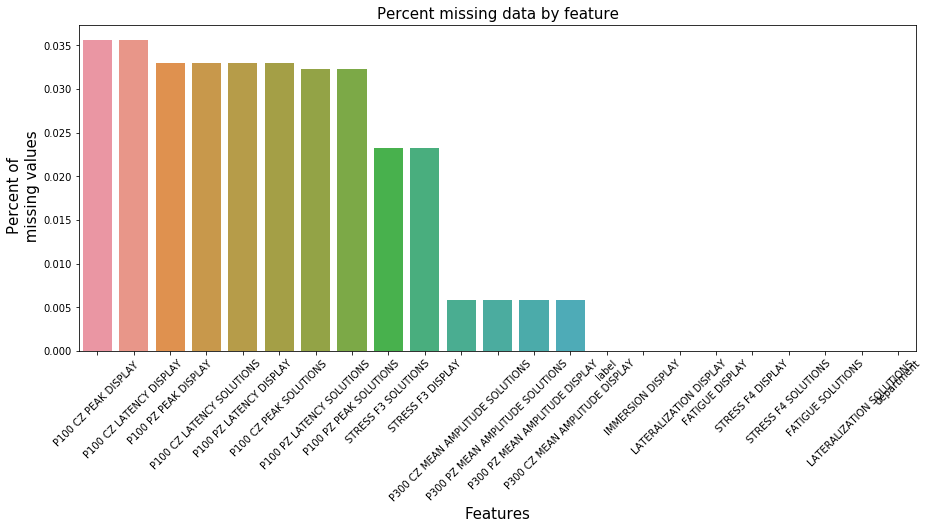

In [10]:
df = df.replace("", np.nan)
total = df.isna().sum().sort_values(ascending=False)
percent = (df.isna().sum()/df.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='45')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15 )
plt.ylabel('Percent of   \n missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

### We decided to not work with imcomplete information, even though it's a small percentage we pruned the data by rows with "Not a number". We based our decision on the strategy to deal with missing data present in  https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-1-dda69d4f88ca  

In [11]:
df.dropna(inplace=True) 

Separating data into training and testing, with a ratio of 0.8 for training and 0.2 to test. This was done assuring that no value is shared between partitions and the sum of both sets would give us the totality of our preprocessed dataset.

In [12]:
LABEL = 'department'
train, test = np.split(df.sample(frac=1), [int(.8*len(df))])
Y_train = train[LABEL].values.astype('int32')
Y_test = test[LABEL].values.astype('int32')

train.drop([LABEL], axis=1, inplace=True)
test.drop([LABEL], axis=1, inplace=True)
X_train = (train.values).astype('float32')
X_test = (test.values).astype('float32')

In [13]:
print("Size of train data: " + str(len(train)))
print("Size of test data: " + str(len(test)))

Size of train data: 1115
Size of test data: 279


From here onwards we'll be testing different classifiers.

# PCA Analysis

### Based upon https://www.kaggle.com/pmmilewski/pca-decomposition-and-keras-neural-network


## Centering

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_sc_train = scaler.transform(X_train)
X_sc_test = scaler.transform(X_test)

## Covariance analysis

In [15]:
pca = PCA(n_components=22)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=22, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Variance ratio per number of components

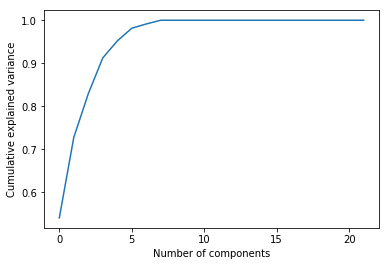

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

Change here as required, we picked 5 because it keeps 0.978 of the cumulative variance, giving us good trade of between number of components and variance.

In [17]:
NCOMPONENTS = 5 

In [18]:
pca = PCA(n_components=NCOMPONENTS)
X_pca_train = pca.fit_transform(X_sc_train)
X_pca_test = pca.transform(X_sc_test)
pca_std = np.std(X_pca_train)

In [19]:
print(X_pca_train.shape)

(1115, 5)


# Neural Network Analysis

In [20]:
model = Sequential()
layers = 3
UNITS_1 = 20
UNITS_2 = 5

### Run the next cell to force CPU usage. Otherwise it may use GPU, and depending on the installation of the tools present on the machine it may or may not work.

In [21]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [22]:
model.add(Dense(UNITS_1, input_dim=NCOMPONENTS, activation='relu'))
model.add(GaussianNoise(pca_std))
for i in range(layers):
    model.add(Dense(UNITS_2, activation='relu'))
    model.add(GaussianNoise(pca_std))
    model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

warnings.filterwarnings("ignore")

Instructions for updating:
Colocations handled automatically by placer.


Experimentation with different loss functions and optimizers, and the very goal was done. We left another option as a commentary.  

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])
history = model.fit(X_pca_train, Y_train, epochs=100, batch_size=256, validation_split=0.15, verbose=0)

# to see the progress unfold
#history = model.fit(X_pca_train, Y_train, epochs=100, batch_size=256, validation_split=0.15, verbose=2)
warnings.filterwarnings("ignore")

Instructions for updating:
Use tf.cast instead.


In [24]:
predictions = model.predict_classes(X_pca_test, verbose=0)
nn_a = accuracy_score(Y_test,predictions)
nn_r = recall_score(Y_test,predictions)
nn_f1 = f1_score(Y_test,predictions)

# SVM Analysis

### Based upon https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/


In [25]:
clf = svm.SVC()
clf.fit(X_pca_train, Y_train)
predictions = clf.predict(X_pca_test)
svm_a = accuracy_score(Y_test,predictions)
svm_r = recall_score(Y_test,predictions)
svm_f1 = f1_score(Y_test,predictions)

# Decision trees Analysis

### Based upon https://blog.goodaudience.com/introduction-to-random-forest-algorithm-with-python-9efd1d8f0157


In [26]:
parameters = {'bootstrap': True,
          'min_samples_leaf': 3,
          'n_estimators': 1000  ,
          'min_samples_split': 10,
          'max_features': 'sqrt',
          'max_depth': 6,
          'max_leaf_nodes': None}

RF_model = RandomForestClassifier(**parameters)
RF_model.fit(X_pca_train, Y_train)
RF_predictions = RF_model.predict(X_pca_test)
rf_a = accuracy_score(Y_test,RF_predictions)
rf_r = recall_score(Y_test,RF_predictions)
rf_f1 = f1_score(Y_test,RF_predictions)

# Final  Results

Please pay attention if every cell of code has been run, this final cells assumes every single cell before as run without issues

In [27]:
print("---------------------------------------")
print('Neural Network Accuracy is:', nn_a*100,' %')
print('Neural Network Recall is:', nn_r*100,' %')
print('Neural Network F1-score is:', nn_f1*100,' %')
print('SVM Accuracy is:', svm_a*100,' %')
print('SVM Recall is:', svm_r*100,' %')
print('SVM F1-score is:', svm_f1*100,' %')
print("Random Forest Accuracy is:", rf_a*100,' %')
print("Random Forest Recall is:", rf_r*100,' %')
print("Random Forest F1-scpre is:", rf_f1*100,' %')

---------------------------------------
Neural Network Accuracy is: 60.93189964157706  %
Neural Network Recall is: 100.0  %
Neural Network F1-score is: 75.7238307349666  %
SVM Accuracy is: 60.93189964157706  %
SVM Recall is: 75.29411764705883  %
SVM F1-score is: 70.13698630136987  %
Random Forest Accuracy is: 57.34767025089605  %
Random Forest Recall is: 62.35294117647059  %
Random Forest F1-scpre is: 64.04833836858006  %
